In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiregressor as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
46,5.1,3.8,1.6,0.2,Iris-setosa
40,5.0,3.5,1.3,0.3,Iris-setosa
88,5.6,3.0,4.1,1.3,Iris-versicolor
127,6.1,3.0,4.9,1.8,Iris-virginica
80,5.5,2.4,3.8,1.1,Iris-versicolor
...,...,...,...,...,...
111,6.4,2.7,5.3,1.9,Iris-virginica
128,6.4,2.8,5.6,2.1,Iris-virginica
65,6.7,3.1,4.4,1.4,Iris-versicolor
62,6.0,2.2,4.0,1.0,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
jackknife_idx = random.choice(iris_dataset.index.to_numpy())
# jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiRegressionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5,
    discretize_continuous=False,
    use_inversed_data_for_training=True
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

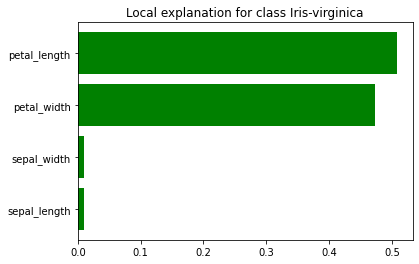

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
140,6.7,3.1,5.6,2.4,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[0.0, 0.0, 1.0]
[0.001338260846006079, 0.019620436874057862, 0.9924262489334]
[0.0013205849, 0.019361287, 0.97931814]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.00052443 0.00714238 0.00376654]
MSE on cv-test  set: [0.00066535 0.00691366 0.00411847]
std on cv-test  set: [9.99212533e-05 3.63033786e-04 2.54419107e-04]


In [11]:
explanation.get_predicted_label()

'Iris-virginica'

In [12]:
explanation.render_explanation_tree("tree_multiregressor.png")

In [13]:
print(explanation.get_decision_rules_for_explanation())

Sklasyfikowano jako 'Iris-virginica', ponieważ:
		cecha petal_length (o wartości 5.6) była > 4.854
	oraz	cecha petal_width (o wartości 2.4) była > 1.749
	oraz	cecha sepal_length (o wartości 6.7) była > 6.02
	oraz	cecha petal_length (o wartości 5.6) była > 5.02



In [14]:
explanation.get_fidelity_loss_on_kfold()

array([0.00289308, 0.00254925, 0.00263202, 0.00314718, 0.00266604])

In [15]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.6202253695199306),
 (3, 0.35513826319924063),
 (1, 0.016537234994373047),
 (0, 0.00809913228645584)]

In [16]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, 0.6315719663291477),
 (3, 0.35035835872521487),
 (1, 0.016223705796217534),
 (0, 0.0018459691494199127)]

In [17]:
explanation.as_map()

{0: [(3, 0.5338210735458998),
  (2, 0.46184235166162446),
  (0, 0.002239966506438473),
  (1, 0.002096608286037407)],
 1: [(2, 0.6315719663291477),
  (3, 0.35035835872521487),
  (1, 0.016223705796217534),
  (0, 0.0018459691494199127)],
 2: [(2, 0.6202253695199306),
  (3, 0.35513826319924063),
  (1, 0.016537234994373047),
  (0, 0.00809913228645584)]}

In [18]:
explainer.discretizer.names

AttributeError: 'NoneType' object has no attribute 'names'

In [ ]:
explainer.discretizer.maxs

Update some attributes to see if probabilities would change

In [ ]:
top_features = explanation.as_map()[predicted_label_id]
top_features